# Assignment 4: Benchmarking Neural Nets with the XOR Problem

### CS 4774 Machine Learning - Department of Computer Science - University of Virginia
In this assignment, you will implement your own neural networks to classify non-linear data from the XOR dataset. For references, you may refer to my [lecture 10](https://docs.google.com/presentation/d/1otQfmMomWctLZKI3hHKAA4lLkbXFtagLaQov8gNh4LI/edit?usp=sharing) and [Colab Notebook 10](https://colab.research.google.com/drive/1x5biI3dP5YvvDEI0wapJcSgQNnATDzNe) if you need additional sample codes to help with your assignment. For deliverables, you must write code in Python/Tensorflow and submit **this** Jupyter Notebook file (.ipynb) to earn a total of 100 pts. Note that you must save your Notebook filename under this format: **yourUvaUserId_assignment_4_ann.ipynb**.



In [221]:
# You might want to use the following packages
import numpy as np
import os
%tensorflow_version 2.x
import tensorflow as tf

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from functools import partial
import pandas as pd

---
## 1. THE DATASET AND VISUALIZATION

We will use the non-linear toy data called the XOR dataset. You may use the code snippet below to generate the train/validate/test set. Feel free to change the number of samples, and noise level. To keep the ratio between the sets consistent, please do not change the test_size and random_state parameters.



(720, 2)
(200, 2)
(80, 2)


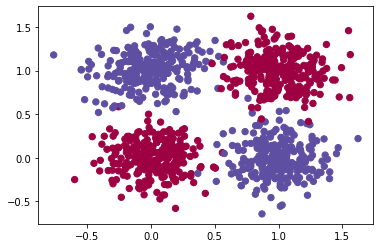

In [195]:
def make_xor(n_points):
    centers = np.array([[0,0],[0,1],[1,0],[1,1]])
    labels = np.array([0,1,1,0])
    data = np.array([]).reshape(-1,3)
    for center, label in zip(centers,labels):
        points = np.random.normal(loc=center,scale=0.2,size=(n_points//4,2))
        points_labels = np.hstack((points,label*np.ones(n_points//4).reshape((-1, 1))))
        data = np.vstack((data,points_labels))
    return (data[:,[0,1]],data[:,2])


X, y = make_xor(1000)
y=y.astype(np.int64)
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=49)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size= 0.1, random_state=49) 
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)


---
## 2. TRAIN A SIMPLE ANN FOR CLASSIFICATION TASK (20 pts)

Use the standard libarary of Neural Net on the training data, and then test the classifier on the test data. You will create a simple ANN with 3 layers: an Input Layer, a Hidden Layer and an Output Layer. For each layer, you can specify the number of nodes appropriate for the XOR problem. Also, feel free to tune the network as you see fit. You have to report the accuracy of the network on the validation set.

In [256]:
from tensorflow import keras

my_model = keras.Sequential()
my_model.add(keras.layers.Dense(2, input_dim=2, activation='relu'))
my_model.add(keras.layers.Dense(8, activation='relu'))
my_model.add(keras.layers.Dense(1, activation='sigmoid'))
my_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

my_model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 200)

my_model.evaluate(x = X_test, y = y_test)

Epoch 1/200
23/23 [==============================] - 0s 7ms/step - loss: 0.7773 - accuracy: 0.4431 - val_loss: 0.7893 - val_accuracy: 0.3250
Epoch 2/200
23/23 [==============================] - 0s 2ms/step - loss: 0.7464 - accuracy: 0.3750 - val_loss: 0.7547 - val_accuracy: 0.2750
Epoch 3/200
23/23 [==============================] - 0s 2ms/step - loss: 0.7274 - accuracy: 0.3014 - val_loss: 0.7296 - val_accuracy: 0.2375
Epoch 4/200
23/23 [==============================] - 0s 2ms/step - loss: 0.7147 - accuracy: 0.2889 - val_loss: 0.7147 - val_accuracy: 0.2625
Epoch 5/200
23/23 [==============================] - 0s 2ms/step - loss: 0.7066 - accuracy: 0.3111 - val_loss: 0.7033 - val_accuracy: 0.3625
Epoch 6/200
23/23 [==============================] - 0s 3ms/step - loss: 0.7007 - accuracy: 0.3750 - val_loss: 0.6953 - val_accuracy: 0.4000
Epoch 7/200
23/23 [==============================] - 0s 2ms/step - loss: 0.6956 - accuracy: 0.4472 - val_loss: 0.6883 - val_accuracy: 0.5125
Epoch 8/200
2

[0.1354680210351944, 0.9549999833106995]

- - -
## 3. IMPLEMENTING YOUR OWN SIMPLE NEURAL NETWORK (60 pts)

Now that you see how the standard library ANN performs on the XOR dataset, you will attempt to implement your own version of the neural network. To help you, a template has been created including the backpropagation. Essensially, you will get the backward gradients for free. However, please note that the backprop implementation assume usage of tanh activation for the hidden layer and softmax for the output layer. There are some subtasks which you need to implement in order to get the network to work properly.

In [215]:
from sklearn.base import BaseEstimator

class MyNeuralNet(BaseEstimator):
    """Your implementation of a simple neural network"""

    def __init__ (self, nn_input_dim, nn_hidden_dim, nn_output_dim):
        """
        Initialize the network with random weights

        @param: nn_input_dim: Number of nodes in the input layer
        @param: nn_hidden_dim: Number of nodes in the hidden layer
        @param: nn_output_dim: Number of nodes in the output layer
        """
        # SUBTASK 1 (10 pts): Initialize the parameters to random values.
        #I used Xavier initilization for the weight and bias matrices/vectors
        np.random.seed(45)
        self.W1 = np.random.normal(loc=0, scale=np.sqrt(1/nn_input_dim), size=(nn_input_dim, nn_hidden_dim))
        self.b1 = np.zeros((1, nn_hidden_dim))
        self.W2 = np.random.normal(loc=0, scale=np.sqrt(1/nn_hidden_dim), size=(nn_hidden_dim, nn_output_dim))
        self.b2 = np.zeros((1, nn_output_dim))
        
    def loss(self, X, y):
        """
        Evaluate the average loss on the dataset
        """

        # Forward propagation will be needed to calculate the loss
        a1,a2 = self.forward_pass(X)
        # SUBTASK 2 (10 pts): Calculate the loss using log-loss probabilities using a2.
        # You will need to return the average loss on the data 
        data_loss = 0
        for i in range(X.shape[0]):
          data_loss += - np.log(a2[i][y[i]])
        return data_loss / X.shape[0]

    def forward_pass(self, X):
        """
        Pass the signal forward through the layers.
        @param: X: feature
        @return: a1: saved value of the output of the hidden layer
        @return: a2: activated return value of the output layer.
        """
        # SUBTASK 3 (20 pts): Implement Forward propagation.
        # Note that you must implement tanh activiation for the hiden layer, and softmax for the output layer
        z1 = np.dot(X, self.W1) + self.b1
        e_z1 = np.exp(z1)
        e_nz1 = np.exp(-z1)
        a1 = ( e_z1 - e_nz1 ) / ( e_z1 + e_nz1 )
        z2 = np.dot(a1, self.W2) + self.b2
        e_z2 = np.exp(z2)
        a2 = e_z2 / np.sum(e_z2, axis = 1, keepdims=True)

        return a1, a2 

    def backward_pass(self,a1,a2,X,y):
        """
        Pass the signal back and compute the gradient

        @param: X: feature
        @param: y: label
        @param: a1: saved value of the output of the hidden layer
        @param: a2: activated return value of the output layer.

        @return: dW1: the gradient of W1
        @return: db1: the gradient of b1
        @return: dW2: the gradient of W2
        @return: db2: the gradient of b2
        """
        # You do not have to change this function, ...
        # unless you are advanced and want to use different activation function.
        m = len(y) # number of example
        delta2 = a2
        y.astype(np.int64)
        delta2[range(m), y] -= 1
        dW2 = (a1.T).dot(delta2)
        db2 = np.sum(delta2, axis=0, keepdims=True)
        delta1 = delta2.dot(self.W2.T) * (1 - np.power(a1, 2))
        dW1 = np.dot(X.T, delta1)
        db1 = np.sum(delta1, axis=0, keepdims=True)
        return dW1, db1, dW2, db2

    def fit(self, X, y, epochs, X_val, y_val, alpha):
        """
        Learns parameters for the neural network and returns the model.
        
        @param: X: the training feature
        @param: y: the train label
        @param: epochs: Number of passes through the training data for gradient descent
        @param: X_val: the feature of validation set
        @param: y_val: the label of validation set
        """

        # Gradient descent. For each batch...
        for i in range(0, epochs+1):

            # Forward pass
            a1,a2 = self.forward_pass(X);

            # Backpropagation
            dW1, db1, dW2, db2 = self.backward_pass(a1,a2,X,y)

            # SUBTASK 4 (10 pts): Compute the gradient descent parameter update
            self.W1 = self.W1 - alpha * dW1
            self.b1 = self.b1 - alpha * db1
            self.W2 = self.W2 - alpha * dW2
            self.b2 = self.b2 - alpha * db2
        
            
            # Print the loss and validation accuracy at current epoch.
            if i % 10 == 0:
                print("Epoch %i/%i - loss: %f - accuracy: %f - val_loss: %f - val_acc: %f" 
                      %(i,epochs, self.loss(X_train, y_train), self.evaluate(X_train, y_train),
                        self.loss(X_val, y_val), self.evaluate(X_val,y_val)))
            


    def evaluate(self, X, y):
        """
        Evaluate the accuracy of the model
        """
        y_pred = self.predict(X)
        return sum(y_pred == y)/len(y)

    def predict(self, X):
        """
        Predict an output

        @param: X: feature
        @return: y_pred: predicted label (0 or 1)
        """
        # SUBTASK 5 (10 pts): Implement the prediction process. 
        # Hint: It should include a forward pass, and then use the class with higher probability.
        a1,a2 = self.forward_pass(X);
        y_pred = np.zeros((X.shape[0]))
        for i in range(X.shape[0]):
          if a2[i][1] > a2[i][0]:
            y_pred[i] = 1;
        return y_pred


    def plot_decision_boundary(self, pred_func):
        """
        Plot a decision boundary for visualization purpose.
        If you don't fully understand this function don't worry, it just generates the contour plot below.
        """
        # Set min and max values and give it some padding
        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
        h = 0.01
        # Generate a grid of points with distance h between them
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        # Predict the function value for the whole gid
        Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        # Plot the contour and training examples
        plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel1)
        plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

---
## 4. REFLECT ON THE COMPARISON BETWEEN YOUR IMPLEMENTATION TO THE STANDARD LIBRARY (20 pts)
Now that you have implemented your own Neural Net class, let's use it! Create at least 3 instances of your Neural Net class, each with a different number of nodes in the hiden layer, tune it with the appropriate learning rate and number of iteration. You will test their performance in the Xor dataset and report the test accuracy metrics for each instance of your neural network.

Based on the test accuracy, compare your models with the standard library version. 

[[ 0.01864978  0.18407524]
 [-0.27941009 -0.14446256]]
Epoch 0/200 - loss: 0.720615 - accuracy: 0.513889 - val_loss: 0.789863 - val_acc: 0.412500
Epoch 10/200 - loss: 1.549050 - accuracy: 0.513889 - val_loss: 1.852766 - val_acc: 0.412500
Epoch 20/200 - loss: 1.177987 - accuracy: 0.513889 - val_loss: 1.407471 - val_acc: 0.412500
Epoch 30/200 - loss: 0.887516 - accuracy: 0.513889 - val_loss: 1.019444 - val_acc: 0.412500
Epoch 40/200 - loss: 0.874572 - accuracy: 0.513889 - val_loss: 1.038852 - val_acc: 0.412500
Epoch 50/200 - loss: 0.242864 - accuracy: 0.923611 - val_loss: 0.267339 - val_acc: 0.887500
Epoch 60/200 - loss: 0.205387 - accuracy: 0.918056 - val_loss: 0.237218 - val_acc: 0.887500
Epoch 70/200 - loss: 0.151562 - accuracy: 0.947222 - val_loss: 0.156805 - val_acc: 0.937500
Epoch 80/200 - loss: 0.147193 - accuracy: 0.945833 - val_loss: 0.152547 - val_acc: 0.937500
Epoch 90/200 - loss: 0.145669 - accuracy: 0.945833 - val_loss: 0.151112 - val_acc: 0.937500
Epoch 100/200 - loss: 0.14

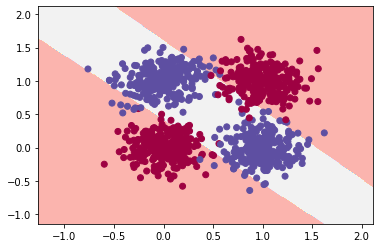

In [257]:
# MODEL 1: 
nn_input_dim = 2 # input layer dimensionality
nn_output_dim = 2 # output layer dimensionality
nn_hidden_dim = 2 # hiden layer dimensionality
alpha = 0.005 # learning rate for gradient descent
epochs = 200 # number of iteration/epochs
# Build a model with 3 layer
myModel1 = MyNeuralNet(nn_input_dim, nn_hidden_dim, nn_output_dim);
myModel1.fit(X_train, y_train, epochs, X_val, y_val, alpha)

# Plot the decision boundary
myModel1.plot_decision_boundary(lambda x: myModel1.predict(x))
# See the weights and biases of the network
print()
print("W1:")
print(pd.DataFrame(myModel1.W1))
print()
print("b1:")
print(pd.DataFrame(myModel1.b1))
print()
print("W2:")
print(pd.DataFrame(myModel1.W2))
print()
print("b2:")
print(pd.DataFrame(myModel1.b2))
print()
print("Test Accuracy: " + str(myModel1.evaluate(X_test, y_test)))
print()

[[ 0.01864978  0.18407524 -0.27941009 -0.14446256 -0.89918007 -1.83627049
   0.20483534 -0.61751964]
 [ 0.27865145  0.66121947 -0.01109076  0.18356207 -1.04179049  0.56704773
  -1.23796888 -0.35005458]]
Epoch 0/200 - loss: 0.990230 - accuracy: 0.487500 - val_loss: 0.836679 - val_acc: 0.587500
Epoch 10/200 - loss: 4.232091 - accuracy: 0.486111 - val_loss: 3.435652 - val_acc: 0.587500
Epoch 20/200 - loss: 2.367612 - accuracy: 0.651389 - val_loss: 1.878463 - val_acc: 0.725000
Epoch 30/200 - loss: 0.074927 - accuracy: 0.975000 - val_loss: 0.044586 - val_acc: 0.975000
Epoch 40/200 - loss: 0.064505 - accuracy: 0.977778 - val_loss: 0.034115 - val_acc: 1.000000
Epoch 50/200 - loss: 0.057842 - accuracy: 0.977778 - val_loss: 0.028969 - val_acc: 1.000000
Epoch 60/200 - loss: 0.052569 - accuracy: 0.980556 - val_loss: 0.025423 - val_acc: 1.000000
Epoch 70/200 - loss: 0.048306 - accuracy: 0.981944 - val_loss: 0.022862 - val_acc: 1.000000
Epoch 80/200 - loss: 0.044857 - accuracy: 0.981944 - val_loss:

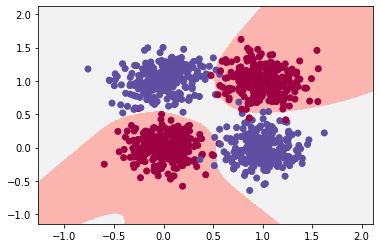

In [258]:
#Model 2:
nn_hidden_dim = 8

# Build a model with 3 layer
myModel2 = MyNeuralNet(nn_input_dim, nn_hidden_dim, nn_output_dim);
myModel2.fit(X_train, y_train, epochs, X_val, y_val, alpha)

# Plot the decision boundary
myModel2.plot_decision_boundary(lambda x: myModel2.predict(x))
# See the weights and biases of the network
print()
print("W1:")
print(pd.DataFrame(myModel2.W1))
print()
print("b1:")
print(pd.DataFrame(myModel2.b1))
print()
print("W2:")
print(pd.DataFrame(myModel2.W2))
print()
print("b2:")
print(pd.DataFrame(myModel2.b2))
print()
print("Test Accuracy: " + str(myModel2.evaluate(X_test, y_test)))
print()

[[ 0.01864978  0.18407524 -0.27941009 -0.14446256 -0.89918007 -1.83627049
   0.20483534 -0.61751964  0.27865145  0.66121947 -0.01109076  0.18356207
  -1.04179049  0.56704773 -1.23796888 -0.35005458]
 [-0.71318847  0.01785034 -0.08591832 -1.09380452 -0.4291742  -0.98557439
  -0.44384774  0.23520645 -1.08991095  1.18108033 -0.35323227  0.47597406
   1.58963938 -1.16974041 -0.33544935 -0.21348631]]
Epoch 0/200 - loss: 0.600636 - accuracy: 0.629167 - val_loss: 0.623237 - val_acc: 0.550000
Epoch 10/200 - loss: 5.200237 - accuracy: 0.513889 - val_loss: 6.760442 - val_acc: 0.412500
Epoch 20/200 - loss: 2.587548 - accuracy: 0.597222 - val_loss: 3.288406 - val_acc: 0.500000
Epoch 30/200 - loss: 0.099357 - accuracy: 0.963889 - val_loss: 0.011112 - val_acc: 1.000000
Epoch 40/200 - loss: 0.073813 - accuracy: 0.970833 - val_loss: 0.010361 - val_acc: 1.000000
Epoch 50/200 - loss: 0.058607 - accuracy: 0.975000 - val_loss: 0.011682 - val_acc: 1.000000
Epoch 60/200 - loss: 0.048780 - accuracy: 0.980556

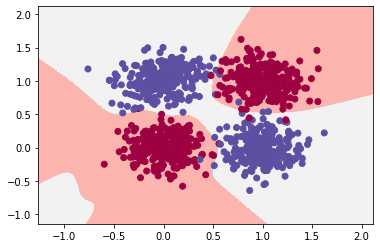

In [259]:
#Model 3:
nn_hidden_dim = 16

# Build a model with 3 layer
myModel3 = MyNeuralNet(nn_input_dim, nn_hidden_dim, nn_output_dim);
myModel3.fit(X_train, y_train, epochs, X_val, y_val, alpha)

# Plot the decision boundary
myModel3.plot_decision_boundary(lambda x: myModel3.predict(x))
# See the weights and biases of the network
print()
print("W1:")
print(pd.DataFrame(myModel3.W1))
print()
print("b1:")
print(pd.DataFrame(myModel3.b1))
print()
print("W2:")
print(pd.DataFrame(myModel3.W2))
print()
print("b2:")
print(pd.DataFrame(myModel3.b2))
print()
print("Test Accuracy: " + str(myModel3.evaluate(X_test, y_test)))
print()

Based on the test accuracy scores, my artificial neural network model outperformed the standard library version. 

I found that using relu as the activation function for the input and hidden layer and sigmoid for the output layer resulted in the highest accuracy score for the library version. I also used 8 nodes for the hidden layer. For the loss function, binary crossentropy procuded the best accuracy and lowest loss, and made the most sense as it is comparical to the categorical cross entropy that was used for my model. The library version produced a test accuracy of 95.5%.

For my model, I used tanh activation for the hidden layer and softmax for the ouput. This was because my model predictions outputs a class probability for the two classes (0 and 1). On the other hand, the library version prediction outputs a label of 0 or 1. This also explains why my model used categorical cross entropy instead of binary cross entropy. I tested my model with 2, 8, and 16 nodes for the hidden layer. They produced test accuracy scores of: 92.5%, 98.5%, and 98.5%. Based on these scores, I would use 8 nodes for the hidden layer as the optimal model. I found that using a learning rate of 0.005 produced the best resutls for all three variations of my model.

I used 200 epochs to train the library version as well as all three variations of my model.

## Reflection
Write at least a paragraph answering these prompts: How did your own network perform? Is there any major differences between the implementations? Finally, reflecting on your experience implementing a learning algorithm for this assignment (Was it hard/easy/fun?, From which part did you learn the most?)!

I believe that my network performed very well. I was very happy with how it turned out since it was able to outperform the standard library version. As I mentioned above, there are definitely major differences between the implementations. These mainly revolve around the activation functions used and the output of the output layers. I thought that implementing an artificial network was challenging but fun. It was definitely not easy, but I found that I was able to get it working properly in a reasonable amount of time. I think that implementing a neural net helped me understand the inner workings at a much better level than just from attending lecture. It made me really focus on what was going on at each part of training and predicting. It was also very statisfying (as always) to see my model work correctly.